In [1]:
MAX_TIME = 1
INIT_SIZE = 5
CLASSIFICATION = True
REGRESSION = False
MOONS = False
MAKE_CLF = False

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '12-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'12-torch_p040025_1min_5init_2023-05-07_10-00-44'

# Chapter 12: Sequential Parameter Optimization
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.56
spotRiver                                 0.0.92
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load Data: Random Data

## Regression

In [8]:
if REGRESSION:
    n_samples = 250
    target_column = "y"
    n_train = 0.6 * n_samples
    n_features = 50
    # Create a random dataset
    X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=1, random_state=42)
    # take X and y and make a pandas dataframe with column names X1, X2, y
    df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))))
    df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
    # split into train and test
    train = df.iloc[:int(n_train), :]
    test = df.iloc[int(n_train):, :]

## Classification

In [9]:
if MOONS:
    n_features = 2
    n_samples = 250
    ds =  make_moons(n_samples, noise=0.5, random_state=0)
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    train = pd.DataFrame(np.hstack((X_train, y_train.reshape(-1, 1))))
    test = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))))
    train.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
    test.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
    train.head()

In [10]:
if MAKE_CLF:
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=40,
        n_redundant=2,
        n_repeated=1,
        n_classes=2,
        flip_y=0.25,
        random_state=0,
        class_sep=0.025,
        shuffle=False,
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    train = pd.DataFrame(np.hstack((X_train, y_train.reshape(-1, 1))))
    test = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))))
    train.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
    test.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
    train.head()


## Load CIFAR Data 

In [11]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [12]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [13]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

In [14]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

In [15]:
# core_model  = RidgeCV
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

In [16]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

### Modify hyperparameter of type numeric and integer (boolean)

In [17]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
# fun_control["core_model_hyper_dict"]
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [18]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [19]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [20]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   1     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [21]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00]])

In [22]:
spot_torch = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_torch.run(X_start=X_start)

[1,  2000] loss: 2.306
[2,  2000] loss: 2.305
[3,  2000] loss: 2.305
[4,  2000] loss: 2.305
Accuracy on hold-out set: 0.1007
Loss on hold-out set: 2.304761162376404
[1,  2000] loss: 2.239
[1,  4000] loss: 1.083
[1,  6000] loss: 0.706
[1,  8000] loss: 0.540
[1, 10000] loss: 0.428
[1, 12000] loss: 0.349
[1, 14000] loss: 0.304
[2,  2000] loss: 2.184
[2,  4000] loss: 1.058
[2,  6000] loss: 0.727
[2,  8000] loss: 0.541
[2, 10000] loss: 0.428
[2, 12000] loss: 0.354
[2, 14000] loss: 0.309
[3,  2000] loss: 2.150
[3,  4000] loss: 1.078
[3,  6000] loss: 0.720
[3,  8000] loss: 0.552
[3, 10000] loss: 0.435
[3, 12000] loss: 0.372
[3, 14000] loss: 0.307
[4,  2000] loss: 2.282
[4,  4000] loss: 1.096
[4,  6000] loss: 0.726
[4,  8000] loss: 0.546
[4, 10000] loss: 0.437
[4, 12000] loss: 0.368
[4, 14000] loss: 0.310
[5,  2000] loss: 2.197
[5,  4000] loss: 1.094
[5,  6000] loss: 0.732
[5,  8000] loss: 0.540
[5, 10000] loss: 0.458
[5, 12000] loss: 0.361
[5, 14000] loss: 0.313
[6,  2000] loss: 2.136
[6,  40

### 4 Results

In [23]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_torch, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_torch =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

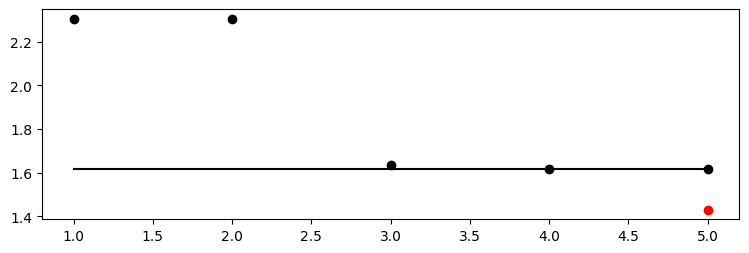

In [24]:
spot_torch.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [25]:
print(gen_design_table(fun_control=fun_control, spot=spot_torch))

| name       | type   |   default |   lower |   upper |                tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  3.0 | transform_power_2_int |         0.00 |         |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  5.0 | transform_power_2_int |         0.00 |         |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.002031674669728904 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                  3.0 | transform_power_2_int |        38.13 | *       |
| epochs     | int    |       3.0 |     1.0 |     4.0 |                  1.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                  0.0 | None                  |  

## Show variable importance

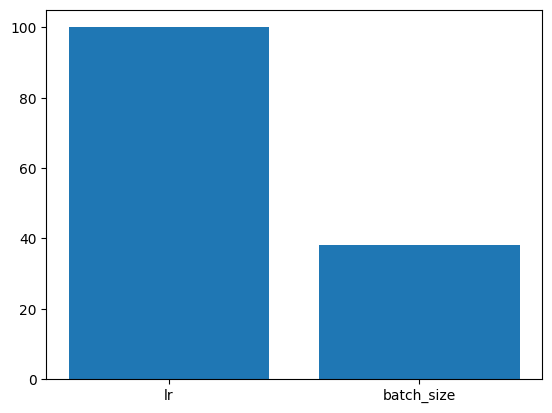

In [26]:
spot_torch.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [27]:
values_default = get_default_hyperparameters_for_core_model(fun_control=fun_control)
values_default

{'l1': 32, 'l2': 32, 'lr': 0.001, 'batch_size': 16, 'epochs': 8, 'k_folds': 2}

In [28]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [29]:
X = spot_torch.to_all_dim(spot_torch.min_X.reshape(1,-1))
print(X)

[[3.00000000e+00 5.00000000e+00 2.03167467e-03 3.00000000e+00
  1.00000000e+00 0.00000000e+00]]


In [30]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 8,
  'l2': 32,
  'lr': 0.002031674669728904,
  'batch_size': 8,
  'epochs': 2,
  'k_folds': 0}]

In [31]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Test Set Accuracy

In [32]:
testset = fun_control["test"]
testset.data.shape

(10000, 32, 32, 3)

In [33]:
model_default.evaluate_hold_out(dataset = testset, shuffle=False)

Accuracy on hold-out set: 0.45225
Loss on hold-out set: 1.5470418968200683


(1.5470418968200683, nan)

In [34]:
model_spot.evaluate_hold_out(dataset = testset, shuffle=False)

Accuracy on hold-out set: 0.2955
Loss on hold-out set: 1.7567195205688477


(1.7567195205688477, nan)

In [35]:
min(spot_torch.y), max(spot_torch.y)

(1.4304374995946885, 2.30529645049572)

In [36]:
trainset = fun_control["train"]

In [37]:
model_default.evaluate_hold_out(dataset=trainset, shuffle=False, test_dataset=testset)

[1,  2000] loss: 1.429
[2,  2000] loss: 1.277
[3,  2000] loss: 1.184
[4,  2000] loss: 1.118
[5,  2000] loss: 1.073
[6,  2000] loss: 1.041
[7,  2000] loss: 1.015
[8,  2000] loss: 0.997
Accuracy on hold-out set: 0.6297
Loss on hold-out set: 1.0781307170391083


(1.0781307170391083, nan)

In [38]:
model_spot.evaluate_hold_out(dataset=trainset, shuffle=False, test_dataset=testset)

[1,  2000] loss: 1.695
[1,  4000] loss: 0.793
[1,  6000] loss: 0.525
[2,  2000] loss: 1.535
[2,  4000] loss: 0.749
[2,  6000] loss: 0.503
Accuracy on hold-out set: 0.4433
Loss on hold-out set: 1.498156957578659


(1.498156957578659, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_torch.y)` and
  * `max_z = max(spot_torch.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

lr:  100.0
batch_size:  38.12731106344787


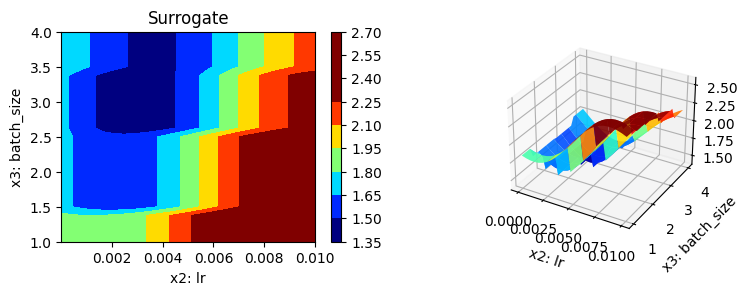

In [39]:
threshold = 0.025
impo = spot_torch.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_torch.y)
max_z = max(spot_torch.y)
n = spot_torch.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_torch.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [40]:
spot_torch.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [41]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_torch.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_torch.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)